# COVID-19 Tweet Sentiment Analysis: LSTM

The goal of this project is to classify tweets about COVID-19 into positive sentiment and negative emotion. Thsi project also serves to make myself more familiar with state-of-the-art NLP models.

## Importing and preprocessing the data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
pd.set_option('display.max_colwidth', 500)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import functional as F

import re
import os
import time
import gc
from tqdm.notebook import tqdm_notebook as tqdm

from keras.preprocessing import text, sequence

from sklearn.metrics import accuracy_score

import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


The data for this project comes from Kaggle ([COVID-19 NLP Text Classification](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)) and contains approx. 45,000 tweets concerning COVID-19.

In [5]:
train = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin1')

In [6]:
train.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


As we can see, the data includes the Twitter username, their location, the date the tweet was posted, the text of the tweet and the corresponding label (extremely negative, negative, neutral, positive, extremely positive).

Since I do not want the project to be too complex, I decide to only work with the text data and omit the rest of the columns. To further simply the task at hand, I decide to turn the problem from a multiclass classification problem into a binary classification problem. As such, I drop the tweets labeled as neutral and merge the classes 'Positive' and 'Extremely Positive', and 'Negative' and 'Extremely Negative'.

For the model to be able to process the labels, I turn them into numerical labels (0 for negative, 1 for positive).

In [7]:
train = train[['OriginalTweet', 'Sentiment']]
test = test[['OriginalTweet', 'Sentiment']]

train = train[train.Sentiment != 'Neutral']
test = test[test.Sentiment != 'Neutral']

label2idx = {'Extremely Negative': 0, 
            'Negative': 0,
            'Positive': 1,
            'Extremely Positive': 1}

train['Sentiment'] = train['Sentiment'].replace(label2idx)
test['Sentiment'] = test['Sentiment'].replace(label2idx)

I then build a function that removes any punctuation, emojis and urls.

In [8]:
def preprocess(data):
    
    """Removes punctuation, emojis and urls form a text."""
    
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text
    
    def remove_url(text):
        return re.sub(r'https?:\/\/\S+|www\.\S+', '', text)

    def remove_emoji(text):
        emoji_pattern = re.compile(
            '['
            u'\U0001F600-\U0001F64F' 
            u'\U0001F300-\U0001F5FF'  
            u'\U0001F680-\U0001F6FF' 
            u'\U0001F1E0-\U0001F1FF'
            u'\U00002702-\U000027B0'
            u'\U000024C2-\U0001F251'
            ']+',
            flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

            
    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    data = data.astype(str).apply(lambda x: remove_url(x))
    data = data.astype(str).apply(lambda x: remove_emoji(x))
    
    return data

In [9]:
x_train = preprocess(train['OriginalTweet'])
y_train = train['Sentiment']
x_test = preprocess(test['OriginalTweet'])
y_test = test['Sentiment']

In [10]:
x_train.sample(3)

30196                      US death toll is way less than estimated  This I hope will bring back consumer confidence  coronavirus  Covid 19  CoronavirusUSA
13325                                  We will get through this by people helping people and not stock piling food and toiletries  selfish pricks  Covid 19
14622     rice prices soar to two year high  traders blame it on  coronavirus panic buying  writes  YasirWardad https   t co hIXzS1DKdo  FE via  febdonline
Name: OriginalTweet, dtype: object

## Word embeddings with GloVe

I decided to use pretrained GloVe embeddings and tokenize the tweets with the Keras Tokenizer.

The Keras tokenizer creates a vocabulary with all the tokens in a text and assigns an index to each tolen according to its frequency in the text. Next, it transforms the text into a sequence of word indices which can then be used as an input for a model.

In [11]:
tokenizer = text.Tokenizer() # instantiate tokenizer class
tokenizer.fit_on_texts(list(x_train) + list(x_test)) # create vocab

x_train = tokenizer.texts_to_sequences(x_train) # transforms training tweets into sequences of word indices
x_test = tokenizer.texts_to_sequences(x_test) # transforms test tweets into sequences of word indices

SEQ_LEN = 110
x_train = sequence.pad_sequences(x_train, maxlen=SEQ_LEN, padding='post') # add padding up to SEQ_LEN
x_test = sequence.pad_sequences(x_test, maxlen=SEQ_LEN, padding='post')

Here's the first tweet in the training set represented as indices (according to the respective token in the vocab).

In [12]:
x_train[0]

array([  570,   977,     2,    39,  2383,   268,     2,  2741,   881,
        1316,  1036,   435,   445,    26,   881,  1316,     6,  2383,
         897,  3827,  3540,  4994,   554,    47,    58,    57,  2557,
          51, 22852,  3131,   176,     6,  1055,  2337,    53,    40,
         110,   259,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0], dtype=int32)

Let's have a look at the pretrained embeddings, such as the embedding for the comma sign.

In [13]:
GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'

In [14]:
with open(GLOVE_EMBEDDING_PATH) as file:
    for line in file:
        print(line)
        break

, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18366 -0.3

I then build an embedding matrix with the pretrained word vectors.

In [15]:
num_tokens = len(tokenizer.word_index)

def get_coefs(word, *arr):
    """Return a tuple (word, embedding_vector)"""
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    """Return dictionary with entries of type {word:embedding_vector}"""
    with open(path) as file:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(file))
    
def build_matrix(word_index, path):
    """Build embedding matrix. Rows represent words according to their index in the vocab. Columns represent the embedding dimensions."""
    
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    unknown_words = []
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [16]:
glove_matrix, unknown_words = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)

In [17]:
glove_matrix.shape, len(unknown_words)

((75037, 300), 44068)

Lastly, I convert the training and test set into torch tensors, put them into a Dataset and split the training set to obtain a validation set.

In [18]:
x_train_torch = torch.tensor(x_train, dtype=torch.long).to(device)
x_test_torch = torch.tensor(x_test, dtype=torch.long).to(device)

y_train_torch = torch.tensor(y_train.values, dtype=torch.long).to(device)

In [19]:
x_train_torch.shape, x_test_torch.shape, y_train_torch.shape

(torch.Size([33444, 110]), torch.Size([3179, 110]), torch.Size([33444]))

In [29]:
len(train_dataset)* 0.8, len(train_dataset) * 0.2

(26755.2, 6688.8)

In [30]:
train_dataset = TensorDataset(x_train_torch, y_train_torch)
test_set = TensorDataset(x_test_torch)

train_set, val_set = torch.utils.data.random_split(train_dataset, [26755, 6689])

## Model

It's time to build a neural net. Here, I build a classifier model with one LSTM layer and two Fully Connected layers, including Dropout.

In [33]:
class Dropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)
        x = x.permute(0, 3, 2, 1)
        x = super().forward(x)
        x = x.permute(0, 3, 2, 1)
        x = x.squeeze(2)
        return x
    
class LSTM_Classifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = Dropout(0.3)
        
        self.rnn = nn.LSTM(input_size=self.embedding_dim,
                           hidden_size=self.hidden_dim)
        self.fc1 = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, inputs):
        
        embedded = self.embedding(inputs)
        embedded_dropout = self.embedding_dropout(embedded)
        
        output, _ = self.rnn(embedded_dropout)
        
        avg_output = torch.mean(output, 1) 
        max_output, _ = torch.max(output, 1) 
        output_conc = torch.cat((avg_output, max_output), 1) 
        
        output = F.relu(self.fc1(output_conc))
        output = self.fc2(output)

        return output

## Training the model

In [34]:
model = LSTM_Classifier(vocab_size=num_tokens, hidden_dim=128, embedding_dim=300, output_dim=1, embedding_matrix=glove_matrix).cuda()

In [35]:
loss_fn = nn.BCEWithLogitsLoss()

In [40]:
def train_model(model, train, val, output_dim, lr, 
               batch_size, n_epochs, update_embedding_weights=False):
    
    if update_embedding_weights:
        params = model.parameters()
    else:
        params = list(model.rnn.parameters()) + list(model.fc1.parameters()) + list(model.fc2.parameters())
    
    optimizer = torch.optim.Adam(params, lr=lr)
    
    train_dl = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)

    all_val_preds = []
    losses_train = []
    losses_val = []
    epoch_loss_train = []
    epoch_loss_val = []
    
    for epoch in range(n_epochs):
        
        start_time = time.time()
        model.train()
        avg_loss_train = 0
        avg_loss_val = 0
        
        for data in train_dl:
            
            x_batch = data[0].cuda()
            y_batch = data[1].float().cuda()

            y_pred = model(x_batch).squeeze(1) 

            loss = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            avg_loss_train += loss.item()
            losses_train.append(loss.item())
        
        avg_loss_train = avg_loss_train/len(train_dl)
        epoch_loss_train.append(avg_loss_train)
        
        model.eval()
        with torch.no_grad():

            for data in val_dl:

                x_batch = data[0].cuda()
                y_batch = data[1].float().cuda()

                y_pred = model(x_batch).squeeze(1)
                loss = loss_fn(y_pred, y_batch)

                avg_loss_val += loss.item()
                losses_val.append(loss.item())

                y_pred = torch.sigmoid(y_pred)
                all_val_preds.append(y_pred)

            avg_loss_val = avg_loss_val/len(val_dl)
            epoch_loss_val.append(avg_loss_val)
        
        elapsed_time = time.time() - start_time
        
        print(f'### Epoch {epoch+1}/{n_epochs}###')
        print(f'Training: loss = {avg_loss_train:.4f}')
        print(f'Validation: loss = {avg_loss_val:.4f}')
        print(f'time = {elapsed_time:.2f} s')
        
    return epoch_loss_train, epoch_loss_val

In [38]:
def plot_loss(loss_train, loss_val):
    fig, axes = plt.subplots(figsize=(12, 8))
    plt.plot(loss_train)
    plt.plot(loss_val)
    plt.legend(['train', 'val'])
    plt.xticks(range(0,21))
    plt.show()

### Baseline model

To have a first look at what the results look like and what to improve on, I train the model with a learning rate of 0.001 and dropout (p=0.3).

In [41]:
losses_train, losses_val = train_model(model, train_set, val_set, output_dim=1, lr=0.001, batch_size=512, n_epochs=20, update_embedding_weights=True)

### Epoch 1/20###
Training: loss = 0.6527
Validation: loss = 0.5238
time = 2.52 s
### Epoch 2/20###
Training: loss = 0.4449
Validation: loss = 0.3825
time = 2.48 s
### Epoch 3/20###
Training: loss = 0.3867
Validation: loss = 0.3481
time = 2.49 s
### Epoch 4/20###
Training: loss = 0.3645
Validation: loss = 0.3270
time = 2.49 s
### Epoch 5/20###
Training: loss = 0.3384
Validation: loss = 0.3087
time = 2.53 s
### Epoch 6/20###
Training: loss = 0.3238
Validation: loss = 0.3083
time = 2.72 s
### Epoch 7/20###
Training: loss = 0.3129
Validation: loss = 0.2917
time = 2.49 s
### Epoch 8/20###
Training: loss = 0.3025
Validation: loss = 0.3074
time = 2.53 s
### Epoch 9/20###
Training: loss = 0.2901
Validation: loss = 0.2960
time = 2.74 s
### Epoch 10/20###
Training: loss = 0.2828
Validation: loss = 0.2891
time = 2.63 s
### Epoch 11/20###
Training: loss = 0.2744
Validation: loss = 0.2907
time = 2.49 s
### Epoch 12/20###
Training: loss = 0.2642
Validation: loss = 0.2753
time = 2.49 s
### Epoch 13/

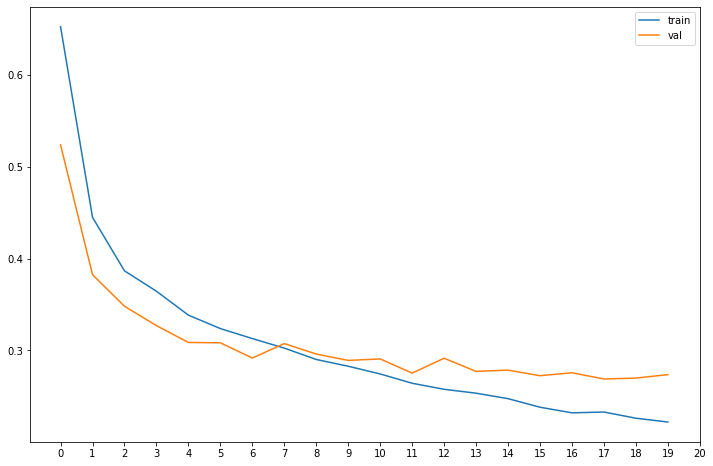

In [42]:
plot_loss(losses_train, losses_val);

This looks alright! My next steps will be to try to improve the model by, e.g., tweeking the hyperparameters, adding more layers, adding a learning rate scheduler, etc.

To be continued...